## 曲线上的随机采样：数值+解方程

## 描述

在随机模拟实验中，在一个给定的曲面上生成均匀随机点是一个常见的需求。  
但是还没发现有太好通用的算法，这里进行一些探索。  


### 定义

我们把问题分解成两个：
1. 在n维空间（n>=2）上的一条曲线上生成均匀随机点
2. 在n维空间（n>=3）上的一条曲面上生成均匀随机点



#### 何为随机？
我们已经知道 **同余发生器** 或者 **混沌迭代式** 都可以生成伪随机数，这里的随机的定义保持一致。
#### 何为均匀随机？
我们把均匀随机定义为某种度量上的随机：
- 把曲线上的均匀随机，定义为沿着曲线的长度均匀随机采样。
- 把曲面上的均匀随机，定义为沿着曲面上的面积均匀采样。


#### 为何不涉及其它维度？
因为都是已经解决的问题。  


维度为1的曲线上的均匀分布，实际上就是一般说的均匀分布 `np.random.rand()` 已经有大量的讨论了。


维度为2的曲面上的均匀分布，实际上就是平面上某一块区域，以二维圆面为例，算法如下：

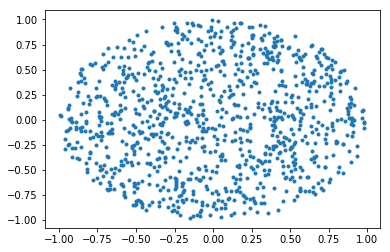

In [3]:
#```python
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def random_surface():
    while True:
        x, y = np.random.rand(2) * 2 - 1
        if x ** 2 + y ** 2 <= 1:
            return x, y


sample = np.array([random_surface() for i in range(1000)])
plt.plot(sample[:, 0], sample[:, 1], '.')
# ```
# ![random_surface2](https://user-images.githubusercontent.com/19920283/63161511-d67edb80-c052-11e9-8cdd-14128c919613.png)

## 曲线上的均匀随机
假设曲线的表示是:  
$$x=\phi(t),y=\psi(t), t\in [a,b]$$  

第一类曲线积分 $\int_{a}^{b} ds$ 就是曲线的长度，  
我们找到x，使得 $\dfrac{\int_{a}^{x} ds}{\int_{a}^{b} ds}=r$，其中$r\in[0,1]$  
也就是$\dfrac{\int_{a}^{x} \sqrt{x'^2+y'^2} dt}{\int_{a}^{b} \sqrt{x'^2+y'^2} dt}=r, r\in[0,1]$

算法就是根据上面的方程，找到$x=f(r)$，然后生成随机的r，进而就找到x了。  

### 案例：圆
$x=\cos t+1,y=\sin t, t\in [0,\pi]$  
$\int_0^t ds = \int_0^t \sqrt{x'^2+y'^2} dt= t$  

方程是 $t/\pi =r$  

代码就有了：

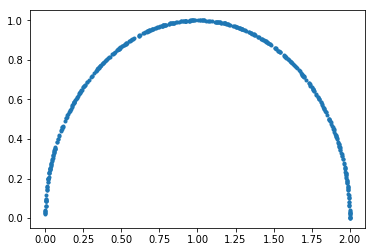

In [5]:
def random_surface():
    r = np.random.rand()
    t = r * np.pi
    x, y = np.cos(t) + 1, np.sin(t)
    return x, y


sample = np.array([random_surface() for i in range(500)])
plt.plot(sample[:, 0], sample[:, 1], '.')


### 缺点与改进
以阿基米德螺旋线$x=t\cos t, y=t\sin t$为例，  
$\int_0^t ds = \int_0^t \sqrt{x'^2+y'^2} dt$  
$= \int_0^t \sqrt{1+t^2}dt$  
$=t/2\sqrt{1+t^2}+1/2 \ln (t+\sqrt{1+t^2})$  


求积分那一步就已经有点计算量了，  
解方程 $t/2\sqrt{1+t^2}+1/2 \ln (t+\sqrt{1+t^2})=r$ 更是几乎不可能。  
因此必须找到一个数值方法。  


- 手算出被积函数的解析形式（相对来说，不很难）
- 使用了scipy的积分算法、解方程算法（因此效率会变低）
- 为了展示是否均匀，r用均匀值，而不是随机值。在实战中改成随机值。
- fprime 是雅克比矩阵，用于解方程时，加快迭代速度，可以省略。根据Lebniz定理，雅克比矩阵正好等于被积函数。

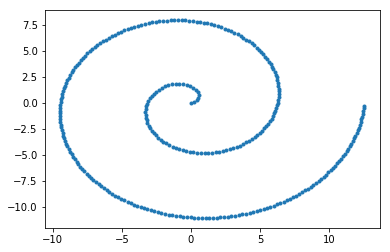

In [9]:
import scipy.optimize as opt
import numpy as np


def func(t):
    # 被积部分
    return np.sqrt(1 + np.square(t))


from scipy import integrate

s, _ = integrate.quad(func, 0, 4 * np.pi)  # 分母

result = []
for i in range(300):
    # r = np.random.rand()
    r = i / 300.
    t = opt.fsolve(lambda t: integrate.quad(func, 0, t)[0] / s - r, [0], fprime=func)
    x = t * np.cos(t)
    y = t * np.sin(t)
    result.append([x, y])

result = np.array(result)

plt.plot(result[:, 0], result[:, 1], '.')
plt.show()


### 方案3

观察到这样的事实，如果把 $f(t)=\sqrt{x'^2+y'^2}$（还需要归一化） 看成一个概率密度函数，那么就可以用蒙特卡洛方法来做了。  


算法步骤：
1. 计算解析形式$f(t)=\sqrt{x'^2+y'^2} dt$
2. 计算$m=\max f(t)$ （或者m比最大值大一些也ok）
2. 在t可能的区域内随机选取一点$t$，计算$f(t)/m$
3. 生成一个随机数$r\in [0,1]$，如果$f(x)/m>r$，则保留x，否则丢弃x并回到2



优缺点：
- 不用解积分，也不用解方程。大大提高效率
- 但是会有大量空运算（丢弃），所以当f不均匀，或者返回太大时，效率变低。不过貌似效率再低也比方案2强。

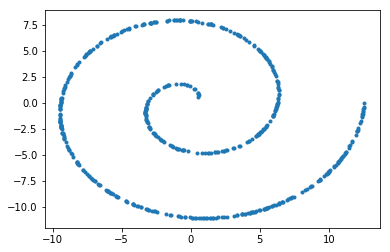

In [10]:
import scipy.optimize as opt
import numpy as np


def func(t):
    # 被积部分
    return np.sqrt(1 + np.square(t))


left, right = 0, 4 * np.pi
m = -opt.minimize(fun=lambda t: -func(t), x0=np.array([0.1]),
                  method=None, jac=None,
                  bounds=((left, right),)).fun[0]

t_list = []
for i in range(1000):
    t = np.random.rand() * (right - left) + left
    if func(t) / m > np.random.rand():
        t_list.append(t)

x = t_list * np.cos(t_list)
y = t_list * np.sin(t_list)
plt.plot(x, y, '.')
plt.show()


## 曲面上的均匀随机

### 推广
回到曲线上均匀分布的推导过程，我们找到方程 $\dfrac{\int_{a}^{x} ds}{\int_{a}^{b} ds}=r$，其中$r\in[0,1]$ 的解，作为随机生成算法。  
由于积分和方程难以解出，求助了数值方法去计算。  


对于曲面上的情况，类似的，  
$\iint_D 1d\sigma=\iint_{\Omega_{xy}}\sqrt{1+(\dfrac{\partial z}{\partial x})^2+(\dfrac{\partial z}{\partial y})^2}dxdy=r$  


## 案例：球面
$z=\sqrt{1-x^2-y^2}$  

$f(x,y)=\sqrt{1+(\dfrac{\partial z}{\partial x})^2+(\dfrac{\partial z}{\partial y})^2}=\sqrt{1/(1-x^2-y^2)}$  


为了符号统一，我们把$f(x,y)$定义在$R^2$上，并且对于原本没有定义的点，定义$f(x,y)=0$  
不影响积分$\int_{-\infty}^{+\infty}\int_{-\infty}^{+\infty} f(x,y)dxdy$  

又记 $g(x)=\int_{-\infty}^{+\infty} f(x,y)dy$  
得到$\int_{-\infty}^{x}g(x)/\int_{-\infty}^{+\infty}g(x)=r$，并求解$x=x'$  
$\int_{-\infty}^{y} f(x',y)dy/\int_{-\infty}^{+\infty} f(x',y)dy=r'$，求解$y=y'$  


之后得到$(x',y')$就是我们要的结果

/home/shouldsee/.local/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


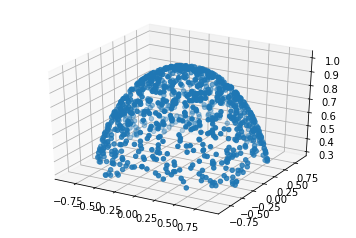

array([0.        , 1.51814042, 2.03135032, 2.22413782, 2.3288371 ,
       2.3940083 , 2.43704523, 2.46581343, 2.48432633, 2.49473205,
       2.49809155, 2.49473205, 2.48432633, 2.46581343, 2.43704523,
       2.3940083 , 2.3288371 , 2.22413782, 2.03135032, 1.51814042])

In [12]:
from scipy import optimize as opt
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')


def bound(x, y):
    return x ** 2 + y ** 2 <= 0.9


def func(x, y):
    if bound(x, y):
        return 1 / np.sqrt(1 - x ** 2 - y ** 2)
    else:
        return 0


x_min, x_max, y_min, y_max = -0.9, 0.9, -0.9, 0.9


def func_g(x):
    g = integrate.quad(lambda y: func(x, y), -np.sqrt(1 - x ** 2), np.sqrt(1 - x ** 2))
    return g[0]


# g(x)的最大值
m1 = -opt.minimize(fun=lambda x: -func_g(x), x0=np.array([0.1]),
                   bounds=((x_min, x_max),)).fun
# f(x,y)的最大值
# m2 = -opt.minimize(fun=lambda xy: -func(xy[0], xy[1]), x0=np.array([0.1, 0.1]),
#                    bounds=((x_min, x_max), (y_min, y_max))).fun

m2 = np.sqrt(10)

result = []
for i in range(1000):
    x = np.random.rand() * (x_max - x_min) + x_min
    if func_g(x) / m1 > np.random.rand():
        not_find = True
        while not_find:
            y = np.random.rand() * (y_max - y_min) + y_min
            if func(x, y) / m2 > np.random.rand():
                result.append([x, y])
                not_find = False

# 整理并绘图
result = np.array(result)

X = result[:, 0]
Y = result[:, 1]
Z = np.sqrt(1 - X ** 2 - Y ** 2)
surf = ax.scatter(X, Y, Z)
plt.show()

# %%
np.array([func_g(i) for i in np.arange(-1, 1, 0.1)]);



考虑把曲面方程变成参数形式（曲线线的情况就是这么干的）。


假设我们的曲面方程式这个形式 $\vec r=\vec r(u,v)$  
曲面积分为 $\iint_{D}=\mid\vec r_u\times\vec r_v\mid dudv$



推导过程就不写了，直接上算法流程
1. 对于通常的曲面可以（并不）轻松地找到上述参数表示形式，使得：
    - $\vec r_u\times\vec r_v \neq 0$
    - $u,v$的边界都是常数（而不是互相有关）
2. 计算 $I(u,v)=\mid\vec r_u\times\vec r_v\mid$
3. 计算 $m=\max I+\delta$（其中$\delta\geq0$可以自行制定，如果对m的计算没有信心，可以指定为一个正数，这个数如果太大，算法效率会有所降低。）
4. 对$u,v$在其边界内均匀采样，并且以$I(u,v)/m$的概率丢弃这次采样结果


以球面为例$\vec r=(\sin u\cos v,\sin u\sin v,\cos u)$  


跑了一下，效果极好

In [10]:
import numpy as np
import scipy.optimize as opt
%matplotlib inline

if 1:
    # 参数方程$r=r(u,v$
    def func(u, v):
        return np.sin(u) * np.cos(v), np.sin(u) * np.sin(v), np.cos(u)


    # r对u的偏导数
    def func_r_u(u, v):
        return np.cos(u) * np.cos(v), np.cos(u) * np.sin(v), -np.sin(u)


    # r对v的偏导数
    def func_r_v(u, v):
        return -np.sin(u) * np.sin(v), np.sin(u) * np.cos(v), 0 * u


    def func_I(u, v):
        r_u = func_r_u(u, v)
        r_v = func_r_v(u, v)
        
        E = np.linalg.norm(r_u, ord=2, )
        G = np.linalg.norm(r_v, ord=2, )
        F = np.dot( r_u, r_v )
        return np.sqrt(E * G - F ** 2)

def sample_sphere_v0(N):




    left, right = 0, 2 * np.pi
    m = -opt.minimize(fun=lambda t: -func_I(t[0], t[1]), x0=np.array([0.1, 0.1]),
                      bounds=((left, right), (left, right))).fun

    m = m + 0.1
    # %%
    points = np.random.rand(N, 2) * np.pi * 2
    result = []
    for point in points:
        if func_I(point[0], point[1]) / m > np.random.rand():
            result.append(point)
    uvs = np.array(result)

    # %%画图


    X, Y, Z = [], [], []
    for point in result:
        u, v = point
        x, y, z = func(u, v)
        X.append(x)
        Y.append(y)
        Z.append(z)

    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)

    coords = np.vstack([X,Y,Z]).T
    return coords, uvs


from pymisca.vis_util import pyvis

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def qc_plot_2d(coords):
    xs,ys,zs = coords.T
#     N = len(xs)
    us = np.arccos(zs)
    vs = np.arctan(ys/xs)
    uvs = np.stack([us,vs],axis=-1)
    uvs = np.nan_to_num(uvs)


#     xbin = np.linspace(0.01,6.3,50,endpoint=0)
#     ybin = np.linspace(0.01,6.3,50,endpoint=0)

    xbin = np.linspace(0.01,6.3/2., 50,endpoint=0)
    ybin = np.linspace(0.01,6.3/4., 50,endpoint=0)
    xlim = xbin.min(),xbin.max()
    ylim = ybin.min(),ybin.max()
    xs,ys = np.meshgrid(xbin,ybin)

    zs = np.vectorize(func_I)(xs,ys)
    fig,axs = plt.subplots(1,3,figsize=[14,4])
    ax = axs[0]
    ax.set_title('theoretical')
    zs1 = zs = zs / zs.sum()
    # max()
    vlim = [0,8E-4]
    pyvis.heatmap(zs,
                  xlim=xlim,ylim=ylim,xlab='u',ylab='v',cname='test',
                  vlim = vlim,
                  
                 ax=ax)
    ax = axs[1]
    ax.set_title('sampled')
    zs = np.histogram2d(*uvs.T,bins=(xbin,ybin))[0].T
    zs2 = zs = zs / zs.sum()
    pyvis.heatmap(zs,
                  xlim=xlim,ylim=ylim,xlab='u',ylab='v',cname='test',
                  vlim = vlim,
                 ax=ax)

    ax = axs[2]
    ax.plot(xbin[:], zs1.mean(axis=0),label='theoretical')
    ax.plot(xbin[:-1], zs2.mean(axis=0),label='sampled')
    ax.set_ylim(0,None)
    ax.legend()
    fig.suptitle("N=%d"%len(coords))
    return ax


def qc_plot_3d(coords):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    surf = ax.scatter(*coords.T, marker='.')
    plt.show()
    return ax

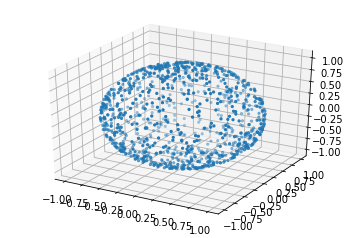

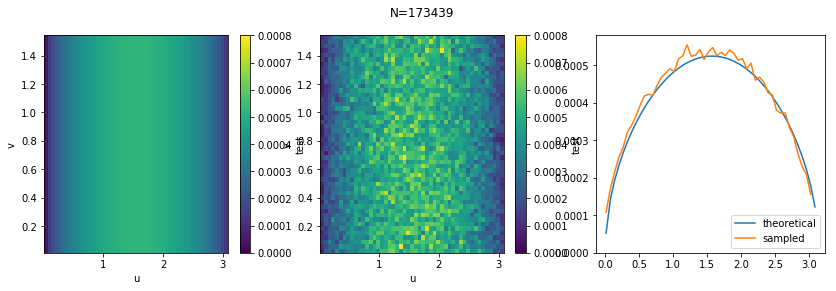

In [12]:
coords,uvs = sample_sphere_v0(250000)
qc_plot_3d(coords[:1000])
qc_plot_2d(coords)

### V2: 用数值方法算偏导数，免于手算偏导的麻烦



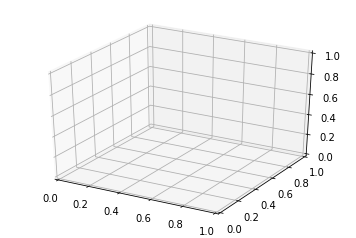

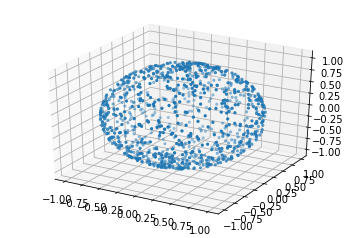

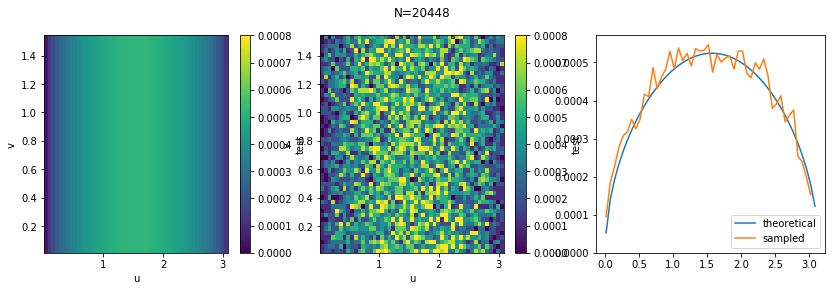

In [14]:

import numpy as np
import scipy.optimize as opt
from scipy.misc import derivative


# 参数方程$r=r(u,v)$
def func(u, v):
    x = np.sin(u) * np.cos(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(u)
    return x, y, z


# r对u的偏导数，可以手算，这里用数值方法
def func_r_u(u, v):
    return derivative(lambda u: func(u, v)[0], u), \
           derivative(lambda u: func(u, v)[1], u), \
           derivative(lambda u: func(u, v)[2], u)


# r对v的偏导数
def func_r_v(u, v):
    return derivative(lambda v: func(u, v)[0], v), \
           derivative(lambda v: func(u, v)[1], v), \
           derivative(lambda v: func(u, v)[2], v)


def func_I(u, v):
    r_u = func_r_u(u, v)
    r_v = func_r_v(u, v)
    E = np.linalg.norm(r_u, ord=2)
    G = np.linalg.norm(r_v, ord=2)
    F = np.dot(r_u, r_v)
    return np.sqrt(E * G - F ** 2)


left, right = 0, 2 * np.pi
m = -opt.minimize(fun=lambda t: -func_I(t[0], t[1]), x0=np.array([0.1, 0.1]),
                  bounds=((left, right), (left, right))).fun

m = m + 0.1
# %%
points = np.random.rand(30000, 2) * np.pi * 2
result = []
for point in points:
    if func_I(point[0], point[1]) / m > np.random.rand():
        result.append(point)

# %%画图

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

X, Y, Z = [], [], []
for point in result:
    u, v = point
    x, y, z = func(u, v)
    X.append(x)
    Y.append(y)
    Z.append(z)

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

# surf = ax.scatter(X, Y, Z, '.')
coords3 = coords = np.vstack([X,Y,Z]).T

qc_plot_3d(coords[:1000])
qc_plot_2d(coords)

# plt.show()



### 投影采样

相比之下, 将三维高斯$\mathcal{N}(0,I_3)$投影到球面上的效果显然有些系统性误差.



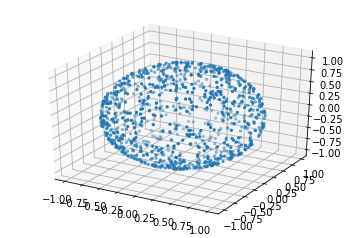

In [ ]:
import IPython.display as ipd
ipd.display(
    ipd.Markdown(
u'''
### 投影采样

相比之下, 将三维高斯$\mathcal{N}(0,I_3)$投影到球面上的效果显然有些系统性误差.

'''
)
)


N = 250000
coords = np.random.normal(size=(N,3))
coords = coords / np.linalg.norm(coords,ord=2,axis=1,keepdims=1)

qc_plot_3d(coords[:1000])
qc_plot_2d(coords)


In [15]:
!jupyter nbconvert --to html 20190819-曲面上随机采样.ipynb
# !jupyter nbconvert --to markdown 20190819-曲面上随机采样.ipynb 
# !jupyter nbconvert --to pdf 20190819-曲面上随机采样.ipynb 

[NbConvertApp] Converting notebook 20190819-曲面上随机采样.ipynb to html
[NbConvertApp] Writing 622510 bytes to 20190819-曲面上随机采样.html
